## Image Classification Exploiting Sparsity

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
# from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
## Encoding convert label to one-hot vector
from keras.utils import to_categorical, plot_model
from keras.models import Sequential, clone_model
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam ,RMSprop
from keras import  backend as K
from keras.callbacks import EarlyStopping
np.random.seed(42)

#### Load data

In [29]:
def visualise_vector(v):
    plt.imshow(v.reshape(28,28),cmap='binary')

In [30]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# plt.figure(figsize=(10,10))
# for i in range(10):
#     plt.subplot(5,5,i+1)
#     plt.xticks([])
#     plt.yticks([])
#     plt.grid(False)
#     plt.imshow(X_train[i], cmap=plt.cm.binary)
#     plt.xlabel(y_train[i])

X = np.concatenate((X_train, X_test))
labels = np.concatenate((y_train, y_test))
X = X.reshape(X.shape[0],-1) / 255
labels = labels.reshape(labels.shape[0],-1)

In [31]:
print(X.shape, labels.shape)

(70000, 784) (70000, 1)


In [32]:
# Parameters
s = np.mean(np.apply_along_axis(np.count_nonzero,axis=1,arr=X))  # Estimate of average sparsity
s = np.ceil(s)
N = X.shape[1]
# m = int(np.ceil(2*s*np.log(N/s)))
m = 300

In [33]:
# Measurement matrix
A = np.random.normal(loc=0, scale=1, size=(m,N))

In [34]:
# Compression
# y0 = A @ X[0,:].T
y = np.apply_along_axis(lambda x: A @ x.T, axis=1, arr=X)
y.shape

(70000, 300)

In [35]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(y)
# y1 = scaler.transform(y)

In [36]:
# # Normalize target variable for faster convergence
# mu = np.mean(y_train)
# std = np.std(y_train)
# y_train_s = (y_train-mu)/std
# y_test_s = (y_test-mu)/std

In [38]:
# LASSO
# lasso_reg = Lasso(alpha=0.1).fit(X_train, y_train_s)
lasso = Lasso(alpha=0.1).fit(A, y.T)

In [39]:
X_reconstructed = lasso.coef_
X_reconstructed.shape

(70000, 784)

In [40]:
MSE = mean_squared_error(X_reconstructed, X)
MSE

0.05237234420728442

In [41]:
# m = 400
# A = np.random.normal(loc=0, scale=1, size=(m,N))
# y = np.apply_along_axis(lambda x: A @ x.T, axis=1, arr=X)
# lasso = Lasso(alpha=1).fit(A, y.T)
# X_reconstructed = lasso.coef_
# MSE = mean_squared_error(X_reconstructed, X)
# print(MSE)


In [42]:
# X_reconstructed = (X_reconstructed - X_reconstructed.min()) / (X_reconstructed.max() - X_reconstructed.min())

241 157
[2]


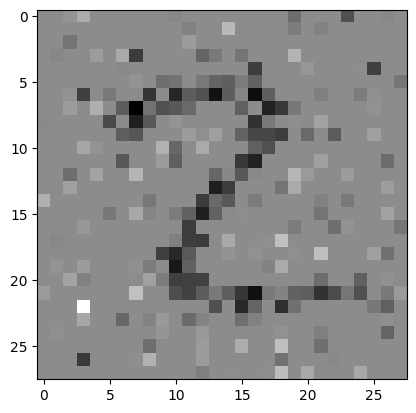

In [43]:
visualise_vector(X_reconstructed[76,:])
print(np.count_nonzero(X_reconstructed[76,:]), np.count_nonzero(X[76,:])) # a=1, m=300
print(labels[76])

In [ ]:
x_76 = X[76,:]
y_76 = A @ x_76.T
X_rec76 = Lasso(alpha=0.1).fit(A,y_76.T).coef_
# X_reconstructed[76,:] == X_rec76

In [44]:
def visualise_pair(v1, v2):
    plt.figure(figsize=(2,4))
    plt.subplot(1,2,1)
    plt.imshow(v1.reshape(28,28),cmap='gray', vmin=0, vmax=1)
    plt.title('Original', fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1,2,2)
    plt.imshow(v2.reshape(28,28),cmap='gray', vmin=0, vmax=1)
    plt.title('Reconstructed', fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.show()

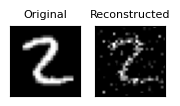

In [45]:
visualise_pair(X[76,:], X_reconstructed[76,:])

In [46]:
X_reconstructed[76,:].min()

-0.9994324125349793

In [47]:
# Splitting
# Using the same random_state ensures that the labels are split the same way in both splits.

X_train_val, X_test, labels_train_val, labels_test = train_test_split(X, labels, test_size=0.2, random_state=42, stratify=labels)
X_train, X_val, labels_train, labels_val = train_test_split(X_train_val, labels_train_val, test_size=1/8, random_state=42, stratify=labels_train_val)

X_rec_val, X_rec_test, labels_rec_val, labels_test = train_test_split(X_reconstructed, labels, test_size=0.2, random_state=42, stratify=labels)
# maybe split into two test datasets for x_rec??
# X_rec_train, X_rec_val, labels_train, labels_val = train_test_split(X_rec_train_val, labels_train_val, test_size=1/8, random_state=42, stratify=labels_train_val)

In [48]:
def ClassificationNN(input_dim, num_labels):

    hidden_units = 256
    dropout = 0.45

    model = Sequential()
    model.add(Dense(hidden_units, input_dim=input_dim))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(hidden_units))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_labels))
    model.add(Activation('softmax'))

    return model

In [49]:
### Now train for classification w/ MNIST

num_labels = len(np.unique(y_train))
num_epochs = 50

# One-hot encoding
labels_train = to_categorical(labels_train)
labels_val = to_categorical(labels_val)
labels_test = to_categorical(labels_test)

# Build model
batch_size = 128
model = ClassificationNN(input_dim=N, num_labels=num_labels)
# rec_model = ClassificationModel(input_dim=N, num_labels=num_labels)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# rec_model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

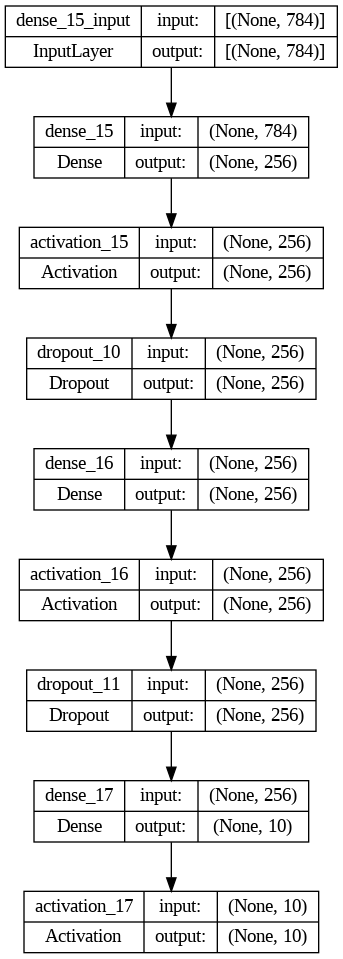

In [ ]:
batch_size = 128
hidden_units = 256
dropout = 0.45
model = Sequential()
model.add(Dense(hidden_units, input_dim=784))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
plot_model(model, to_file='mlp-mnist.png', show_shapes=True)

In [50]:
#Train model
history = model.fit(X_train,
          labels_train,
          validation_data = (X_val,labels_val),
          epochs=num_epochs,
          batch_size=batch_size,
          shuffle=True,
          verbose=2,
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])
# rec_model.fit(X_rec_train, labels_train, validation_data = (X_rec_val,labels_val), epochs=num_epochs, batch_size=batch_size)

Epoch 1/50
383/383 - 6s - loss: 0.4608 - accuracy: 0.8572 - val_loss: 0.1810 - val_accuracy: 0.9461 - 6s/epoch - 17ms/step
Epoch 2/50
383/383 - 4s - loss: 0.2050 - accuracy: 0.9393 - val_loss: 0.1306 - val_accuracy: 0.9606 - 4s/epoch - 10ms/step
Epoch 3/50
383/383 - 4s - loss: 0.1578 - accuracy: 0.9535 - val_loss: 0.1119 - val_accuracy: 0.9679 - 4s/epoch - 11ms/step
Epoch 4/50
383/383 - 4s - loss: 0.1370 - accuracy: 0.9579 - val_loss: 0.0975 - val_accuracy: 0.9710 - 4s/epoch - 9ms/step
Epoch 5/50
383/383 - 4s - loss: 0.1171 - accuracy: 0.9644 - val_loss: 0.0965 - val_accuracy: 0.9721 - 4s/epoch - 10ms/step
Epoch 6/50
383/383 - 4s - loss: 0.1058 - accuracy: 0.9671 - val_loss: 0.0928 - val_accuracy: 0.9730 - 4s/epoch - 9ms/step
Epoch 7/50
383/383 - 4s - loss: 0.0956 - accuracy: 0.9708 - val_loss: 0.0832 - val_accuracy: 0.9743 - 4s/epoch - 10ms/step
Epoch 8/50
383/383 - 4s - loss: 0.0884 - accuracy: 0.9724 - val_loss: 0.0824 - val_accuracy: 0.9756 - 4s/epoch - 10ms/step
Epoch 9/50
383/383

In [51]:
min(history.history['val_loss'])

0.07408899813890457

In [52]:
model.evaluate(X_val, labels_val, verbose=0)

[0.07408900558948517, 0.978857159614563]

In [53]:
loss, acc = model.evaluate(X_test, labels_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))
# loss, acc = rec_model.evaluate(X_rec_test, labels_test, batch_size=batch_size)
# print("\nTest accuracy: %.1f%%" % (100.0 * acc))
# loss, acc = rec_model.evaluate(X_test, labels_test, batch_size=batch_size)
# print("\nTest accuracy: %.1f%%" % (100.0 * acc))
loss, acc = model.evaluate(X_rec_test, labels_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

110/110 [==============================] - 1s 5ms/step - loss: 0.0698 - accuracy: 0.9799

Test accuracy: 98.0%
110/110 [==============================] - 0s 4ms/step - loss: 0.1613 - accuracy: 0.9494

Test accuracy: 94.9%


In [54]:
print(f"Accuracy = {100*acc:.2f}%")

Accuracy = 94.94%


##### Draft - Ignore

In [26]:
# IMG = pd.read_csv('/content/Project_Data_EE4C12_CE_IMG.csv', header=None)
# IMG.dropna(inplace=True)
# IMG = IMG.astype(int)
# labels = IMG.iloc[:,0]
# data = IMG.iloc[:,1:]

In [27]:
# C = 3244
# image = data.iloc[C,:].values.reshape(28,28)
# plt.figure(figsize=(2,2))
# plt.imshow(image, cmap='gray')
# print(f'The image shows the number {labels[C]}\n')

In [28]:
# unique, counts = np.unique(y_train, return_counts=True)
# dict(zip(unique, counts))

In [29]:
# plt.imshow(X[1000,:].reshape(28,28), cmap = 'gray')